In [1]:
import os
import pickle
import zipfile
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing import image
import matplotlib.pyplot as plt

In [2]:

class Distiller(keras.Model):
    def __init__(self, student):
        super(Distiller, self).__init__()
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft pseudo-labels
            alpha: weight to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute pseudo-labels using soft targets
            pseudo_labels = tf.nn.softmax(student_predictions / self.temperature, axis=1)

            # Compute distillation loss
            distillation_loss = self.distillation_loss_fn(
                pseudo_labels,
                tf.nn.softmax(y / self.temperature, axis=1),
            )
            loss = self.alpha * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"distillation_loss": distillation_loss})
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        distillation_loss = self.distillation_loss_fn(
            tf.nn.softmax(y / self.temperature, axis=1),
            tf.nn.softmax(y_prediction / self.temperature, axis=1),
        )

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"distillation_loss": distillation_loss})
        return results

    def call(self, data, training=False): 
        # You don't need this method for training.
        # So just pass.
        pass


In [3]:
import splitfolders
splitfolders.ratio('plantvillage-dataset/color', output="output", seed=1337, ratio=(.8, 0.1,0.1))

In [4]:
TRAINING_DIR = "./output/train"
train_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode='categorical',
                                                    batch_size=500,
                                                    target_size=(250, 250))

VALIDATION_DIR = "./output/test"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              class_mode='categorical',
                                                              batch_size=500,
                                                              target_size=(250, 250))


Found 43429 images belonging to 38 classes.
Found 5459 images belonging to 38 classes.


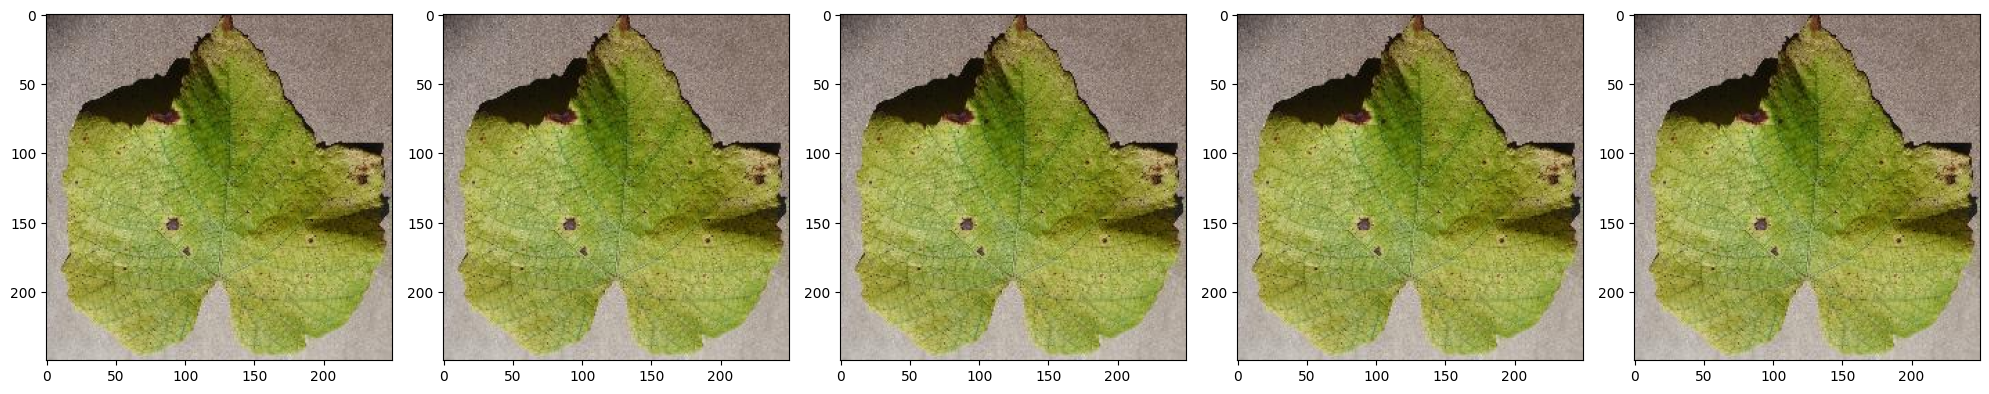

In [5]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [6]:
train_y=train_generator.classes


In [7]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(train_y)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [8]:

# Create the student
student = keras.Sequential(
    [
        keras.Input(shape=(250, 250, 3)),
        layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(n_classes),
    ],
    name="student",
)

# Clone student for later comparison
student_scratch = keras.models.clone_model(student)

In [9]:
student.summary()

Model: "student"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 16)      448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 125, 125, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 125, 125, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 63, 63, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                      

In [10]:
student.compile(
    optimizer=keras.optimizers.legacy.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc'],
)

In [11]:
student_history = student.fit(train_generator, validation_data=validation_generator, epochs=5)


Epoch 1/5
87/87 [==============================] - 143s 2s/step - loss: 1.8393 - acc: 0.5053 - val_loss: 1.0120 - val_acc: 0.7206
Epoch 2/5
87/87 [==============================] - 129s 1s/step - loss: 0.8073 - acc: 0.7684 - val_loss: 0.6823 - val_acc: 0.8044
Epoch 3/5
87/87 [==============================] - 122s 1s/step - loss: 0.5511 - acc: 0.8394 - val_loss: 0.5536 - val_acc: 0.8353
Epoch 4/5
87/87 [==============================] - 125s 1s/step - loss: 0.4238 - acc: 0.8755 - val_loss: 0.4938 - val_acc: 0.8538
Epoch 5/5
87/87 [==============================] - 126s 1s/step - loss: 0.3444 - acc: 0.8967 - val_loss: 0.4667 - val_acc: 0.8641


In [12]:
# Initialize and compile distiller with student
self_distiller = Distiller(student=student)
self_distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Train student with self-distillation
self_history = self_distiller.fit(train_generator, validation_data=validation_generator, epochs=5)

Epoch 1/5
87/87 [==============================] - 128s 1s/step - accuracy: 0.3777 - distillation_loss: 0.0144 - val_accuracy: 0.3528 - val_distillation_loss: 9.5482e-04
Epoch 2/5
87/87 [==============================] - 124s 1s/step - accuracy: 0.4405 - distillation_loss: 6.1915e-04 - val_accuracy: 0.4495 - val_distillation_loss: 4.0507e-04
Epoch 3/5
87/87 [==============================] - 122s 1s/step - accuracy: 0.5274 - distillation_loss: 3.2290e-04 - val_accuracy: 0.5173 - val_distillation_loss: 2.6796e-04
Epoch 4/5
87/87 [==============================] - 127s 1s/step - accuracy: 0.5922 - distillation_loss: 2.1993e-04 - val_accuracy: 0.5525 - val_distillation_loss: 1.9340e-04
Epoch 5/5
87/87 [==============================] - 124s 1s/step - accuracy: 0.6328 - distillation_loss: 1.7377e-04 - val_accuracy: 0.5774 - val_distillation_loss: 1.6545e-04


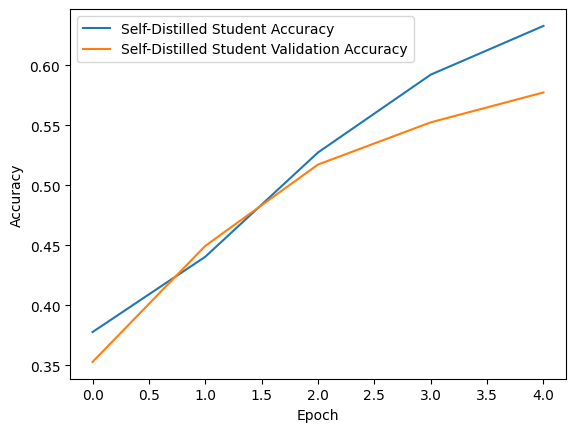

In [13]:
# Plot training history for self-distilled student
plt.plot(self_history.history['accuracy'], label='Self-Distilled Student Accuracy')
plt.plot(self_history.history['val_accuracy'], label='Self-Distilled Student Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
# Evaluate self-distilled student model
self_results = self_distiller.evaluate(validation_generator)
print("Self-Distilled Student Model Evaluation:")
print("Accuracy:", self_results[1])

11/11 [==============================] - 6s 573ms/step - accuracy: 0.5774 - distillation_loss: 1.8041e-04
Self-Distilled Student Model Evaluation:
Accuracy: 0.00016810274973977357


In [17]:
# Train student from scratch
student_scratch.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

scratch_history = student_scratch.fit(train_generator, validation_data=validation_generator, epochs=5)


Epoch 1/5
87/87 [==============================] - 131s 1s/step - loss: 1.6665 - accuracy: 0.5512 - val_loss: 0.9178 - val_accuracy: 0.7282
Epoch 2/5
87/87 [==============================] - 128s 1s/step - loss: 0.7016 - accuracy: 0.7973 - val_loss: 0.6199 - val_accuracy: 0.8186
Epoch 3/5
87/87 [==============================] - 132s 2s/step - loss: 0.4997 - accuracy: 0.8524 - val_loss: 0.5119 - val_accuracy: 0.8540
Epoch 4/5
87/87 [==============================] - 136s 2s/step - loss: 0.3976 - accuracy: 0.8804 - val_loss: 0.5035 - val_accuracy: 0.8549
Epoch 5/5
87/87 [==============================] - 134s 2s/step - loss: 0.3221 - accuracy: 0.9059 - val_loss: 0.4136 - val_accuracy: 0.8776


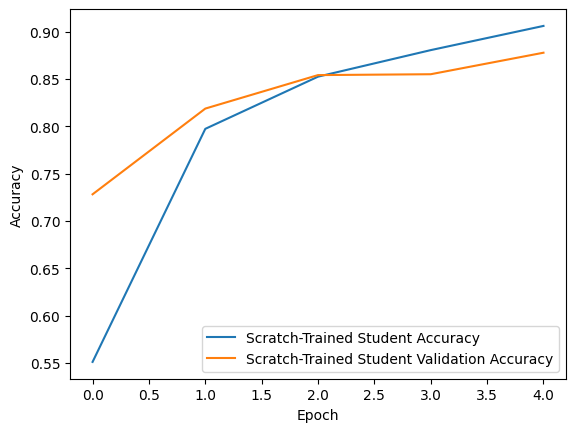

In [18]:
# Plot training history for student trained from scratch
plt.plot(scratch_history.history['accuracy'], label='Scratch-Trained Student Accuracy')
plt.plot(scratch_history.history['val_accuracy'], label='Scratch-Trained Student Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
# Evaluate student model trained from scratch
scratch_results = student_scratch.evaluate(validation_generator)
print("Student Model Trained from Scratch Evaluation:")
print("Accuracy:", scratch_results[1])


11/11 [==============================] - 8s 680ms/step - loss: 0.4136 - accuracy: 0.8776
Student Model Trained from Scratch Evaluation:
Accuracy: 0.877633273601532
